In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import yfinance as yf
from datetime import datetime

In [2]:
df = pd.read_csv("EURUSD_D1MV1_Proyectos1.csv")
df

,Time,Open,High,Low,Close,Volume
0,02/10/2008 00:00,1.39635,1.39715,1.37455,1.37860,788913
1,03/10/2008 00:00,1.37860,1.39065,1.37025,1.37705,868945
2,05/10/2008 00:00,1.36686,1.37040,1.36100,1.36490,36050
3,06/10/2008 00:00,1.36490,1.36700,1.34430,1.35150,1128980
4,07/10/2008 00:00,1.35150,1.37425,1.34815,1.35700,817008
...,...,...,...,...,...,...
5008,06/10/2024 00:00,1.09620,1.09717,1.09620,1.09705,12482
5009,07/10/2024 00:00,1.09705,1.09868,1.09542,1.09742,267157
5010,08/10/2024 00:00,1.09742,1.09971,1.09608,1.09753,227364
5011,09/10/2024 00:00,1.09754,1.09787,1.09362,1.09394,175349


In [3]:
df.isnull().sum()

Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Obtener las variables principales con una matriz de correlación

In [4]:
# Convertir la columna 'Time' a formato de fecha y establecerla como índice
df['Time'] = pd.to_datetime(df['Time'], format='%d/%m/%Y %H:%M')
df.set_index('Time', inplace=True)

# Generar la matriz de correlación
correlation_matrix = df.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)

            Open      High       Low     Close    Volume
Open    1.000000  0.999251  0.999267  0.998604 -0.147924
High    0.999251  1.000000  0.998775  0.999276 -0.137079
Low     0.999267  0.998775  1.000000  0.999298 -0.158502
Close   0.998604  0.999276  0.999298  1.000000 -0.147560
Volume -0.147924 -0.137079 -0.158502 -0.147560  1.000000


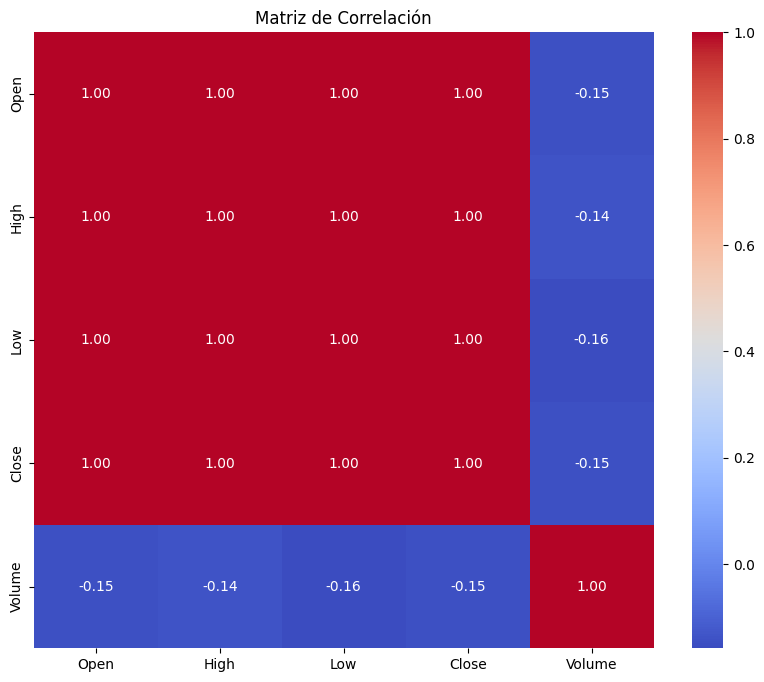

In [5]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

## LOW

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import joblib
import torch
import torch.nn as nn

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


#### Slide window

In [8]:
close_prices = df['Low'].values.reshape(-1, 1) # solo close price en formato numpy

scaler = MinMaxScaler(feature_range=(0, 1))#Normalizar los datos gracias a la LSTM
normalized_close = scaler.fit_transform(close_prices)

In [9]:
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, 0]) 
        y.append(data[i + window_size, 0])   
    return np.array(X), np.array(y)

window_size = 10 # El tamaño de ventana para cada predicción futura
X, y = create_sliding_window(normalized_close, window_size)

### Transformer

In [10]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convertir a tensores y ajustar dimensiones
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # (samples, sequence_length, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)  # (samples, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

In [11]:
# Move data to GPU
X_train = X_train.to('cuda')
y_train = y_train.to('cuda')

Modelo

In [12]:
# Modelo Transformer ajustado
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_heads, num_layers, hidden_dim):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_dim)
        self.transformer = nn.Transformer(
            d_model=hidden_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = self.encoder(x)  # Proyección inicial
        x = self.transformer(x, x)  # Solo usamos el encoder
        out = self.fc(x[:, -1, :])  # Basado en el último paso
        return out

Entrenamiento

In [13]:
# Hiperparámetros del modelo
input_size = 1  # Solo una característica: Close
output_size = 1
num_heads = 4
num_layers = 4#era 2
hidden_dim = 128

# Instanciar el modelo
model = TransformerModel(input_size, output_size, num_heads, num_layers, hidden_dim)

# Move model to GPU
model = model.to('cuda')

# Configuración del optimizador y pérdida
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Entrenamiento del modelo
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward y cálculo de pérdida
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward y optimización
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6}')


c:\ProgramData\anaconda3\envs\machineV2\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/200], Loss: 0.883519
Epoch [2/200], Loss: 1.60966
Epoch [3/200], Loss: 0.538012
Epoch [4/200], Loss: 0.0704939
Epoch [5/200], Loss: 0.254295
Epoch [6/200], Loss: 0.383919
Epoch [7/200], Loss: 0.29975
Epoch [8/200], Loss: 0.15129
Epoch [9/200], Loss: 0.0618277
Epoch [10/200], Loss: 0.0659897
Epoch [11/200], Loss: 0.120017
Epoch [12/200], Loss: 0.168034
Epoch [13/200], Loss: 0.168973
Epoch [14/200], Loss: 0.133664
Epoch [15/200], Loss: 0.0903585
Epoch [16/200], Loss: 0.0579652
Epoch [17/200], Loss: 0.0445898
Epoch [18/200], Loss: 0.0570266
Epoch [19/200], Loss: 0.0775171
Epoch [20/200], Loss: 0.0911024
Epoch [21/200], Loss: 0.0920283
Epoch [22/200], Loss: 0.0784139
Epoch [23/200], Loss: 0.0579569
Epoch [24/200], Loss: 0.0454048
Epoch [25/200], Loss: 0.0391349
Epoch [26/200], Loss: 0.0398158
Epoch [27/200], Loss: 0.048133
Epoch [28/200], Loss: 0.055919
Epoch [29/200], Loss: 0.0522541
Epoch [30/200], Loss: 0.0507689
Epoch [31/200], Loss: 0.0405546
Epoch [32/200], Loss: 0.032917
Ep

Evaluar y predecir

In [14]:
model = model.to('cpu')
X_train = X_train.to('cpu')
y_train = y_train.to('cpu')
# Evaluación
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    predictions = scaler.inverse_transform(predictions.detach().numpy())  # Desnormalizar
    y_test_actual = scaler.inverse_transform(y_test.detach().numpy())     # Desnormalizar

# Métrica de evaluación
rmse = np.sqrt(np.mean((predictions - y_test_actual) ** 2))
print(f'RMSE: {rmse:.4f}')

RMSE: 0.0111


In [15]:
# Asegúrate de que las predicciones del Transformer estén desnormalizadas
predicted_transformer = predictions

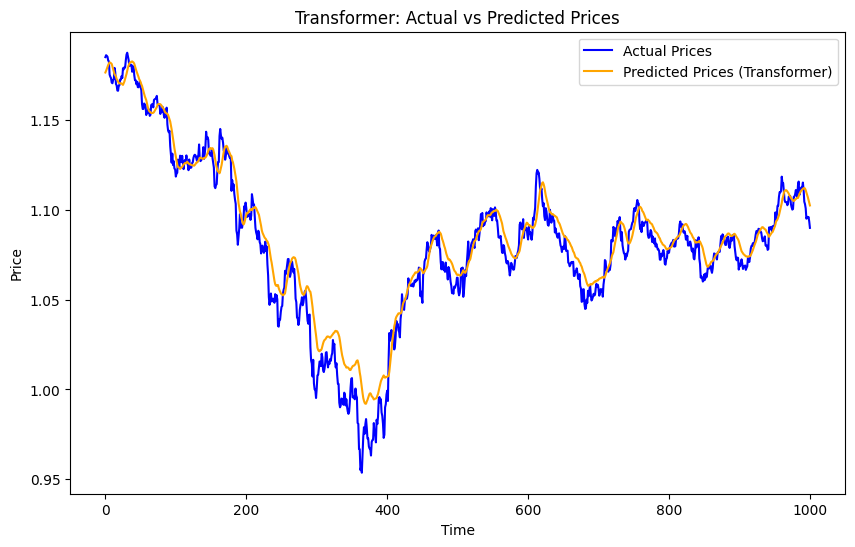

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices (Transformer)', color='orange')
plt.title('Transformer: Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [17]:
#Guardar modelo
torch.save(model.state_dict(), 'transformer_model_weights_Low.pth')

### LT - Linear Trend

In [18]:
X_LT, y_LT = create_sliding_window(close_prices, window_size=10) # Ventanas deslizantes

In [19]:
# Dividir en entrenamiento y prueba (80% de entrenamiento)
split_index = int(len(X) * 0.8)
X_train_LT, X_test_LT = X_LT[:split_index], X_LT[split_index:]
y_train_LT, y_test_LT = y_LT[:split_index], y_LT[split_index:]

In [20]:
# Entrenar el modelo de regresión lineal
model_LT = LinearRegression()
model_LT.fit(X_train_LT, y_train_LT)

LinearRegression()

In [21]:
# Realizar predicciones
predicted_LT = model_LT.predict(X_test_LT)

In [22]:
# Calcular el error
mse_LT = mean_squared_error(y_test_LT, predicted_LT)
rmse_LT = np.sqrt(mse_LT)

In [23]:
# Guardar modelo 
#joblib.dump(model_LT, 'model_LT.pkl')

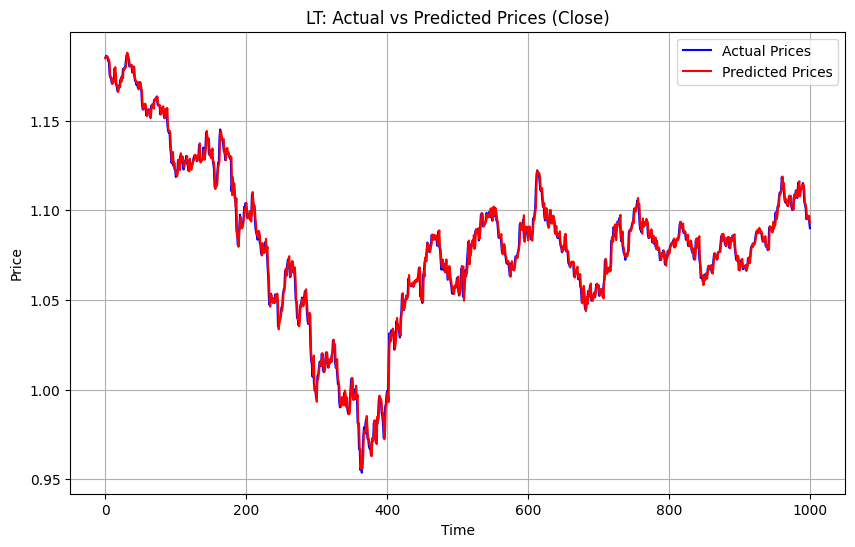

0.0041610156046637805

In [24]:
# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test_LT, label='Actual Prices', color='blue')
plt.plot(predicted_LT, label='Predicted Prices', color='red')
plt.title('LT: Actual vs Predicted Prices (Close)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
rmse_LT

### SETAR - Self-Exciting Threshold AutoRegressive

In [25]:
threshold = np.median(close_prices) # usar la media como umbral

In [26]:
# Crear función para asignar regímenes
def assign_regime(value, threshold):
    return 0 if value <= threshold else 1

regimes = np.array([assign_regime(value, threshold) for value in close_prices.flatten()])

In [27]:
# Crear subconjuntos para cada régimen
X_SETAR, y_SETAR = create_sliding_window(close_prices, window_size)
regime_labels = regimes[window_size:]

In [28]:
# Dividir subconjuntos por régimen
X_regime_0 = X_SETAR[regime_labels == 0]
y_regime_0 = y_SETAR[regime_labels == 0]
X_regime_1 = X_SETAR[regime_labels == 1]
y_regime_1 = y_SETAR[regime_labels == 1]

In [29]:
# Entrenar modelos lineales independientes para cada régimen
model_regime_0 = LinearRegression()
model_regime_0.fit(X_regime_0, y_regime_0)
model_regime_1 = LinearRegression()
model_regime_1.fit(X_regime_1, y_regime_1)

LinearRegression()

In [30]:
# Predicción en los datos de prueba
predicted_SETAR = []
for i in range(len(X_test_LT)):
    current_regime = assign_regime(X_test_LT[i][-1], threshold)  # Determinar régimen actual
    if current_regime == 0:
        predicted_SETAR.append(model_regime_0.predict([X_test_LT[i]])[0])
    else:
        predicted_SETAR.append(model_regime_1.predict([X_test_LT[i]])[0])

# Calcular error
mse_SETAR = mean_squared_error(y_test_LT, predicted_SETAR)
rmse_SETAR = np.sqrt(mse_SETAR)

In [31]:
# Guardar modelo
#joblib.dump(model_regime_0, 'model_SETAR_regime_0.pkl')
#joblib.dump(model_regime_1, 'model_SETAR_regime_1.pkl')

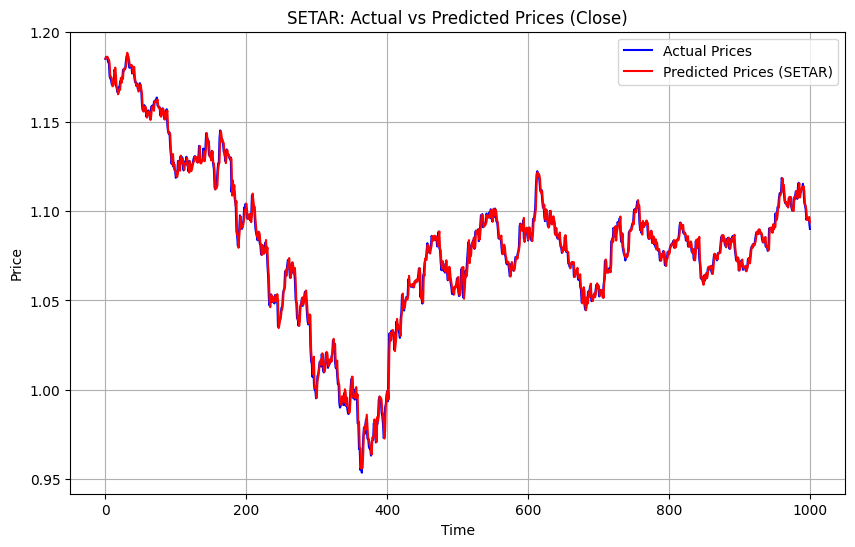

0.004140203136658002

In [32]:
# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(y_test_LT, label='Actual Prices', color='blue')
plt.plot(predicted_SETAR, label='Predicted Prices (SETAR)', color='red')
plt.title('SETAR: Actual vs Predicted Prices (Close)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
rmse_SETAR

### Comparación directa y desnormalización de valores

In [33]:
results = {
    "Actual": y_test_actual.flatten(),  # Valores reales (desnormalizados)
    "Transformer": np.array(predicted_transformer).flatten(),  # Predicciones del Transformer
    "LT": predicted_LT.flatten(),  # Predicciones de Linear Trend
    "SETAR": np.array(predicted_SETAR).flatten()   # Predicciones de SETAR
}

In [34]:
# Calcular métricas (RMSE) para cada modelo
rmse_results = {
    "Transformer": np.sqrt(mean_squared_error(results["Actual"], results["Transformer"])),
    "LT": np.sqrt(mean_squared_error(results["Actual"], results["LT"])),
    "SETAR": np.sqrt(mean_squared_error(results["Actual"], results["SETAR"]))
}

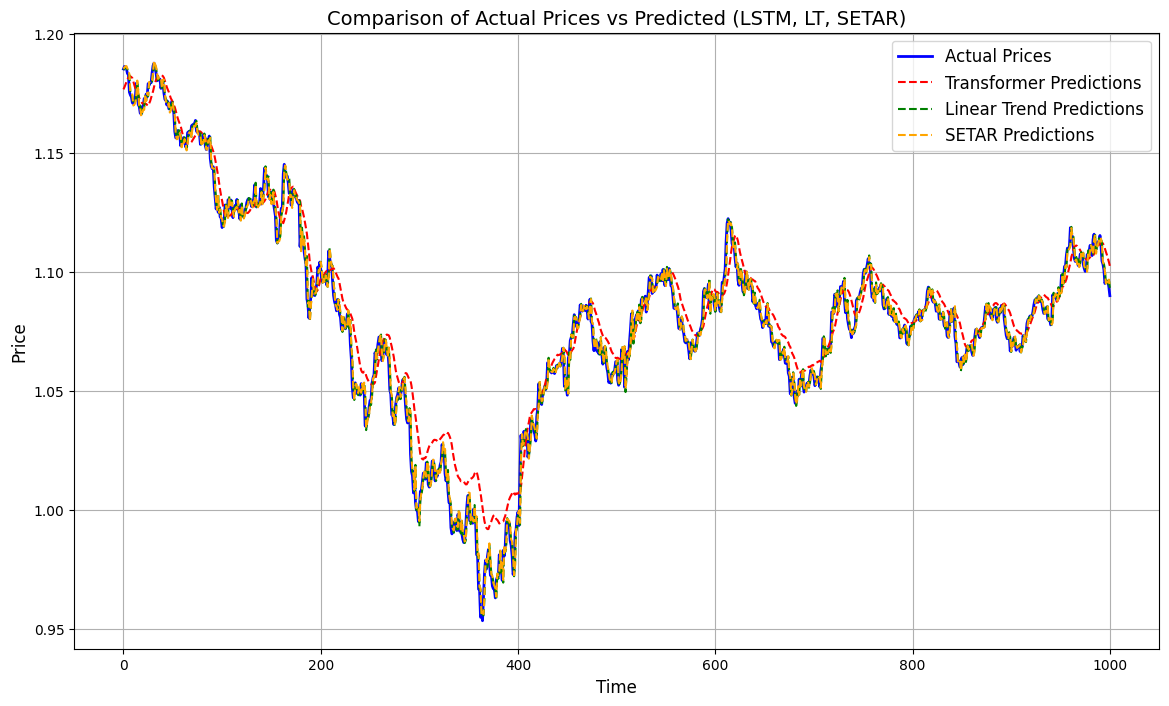

RMSE de los modelos


{'Transformer': 0.011135965,
 'LT': 0.004161015976326545,
 'SETAR': 0.004140203630790819}

In [35]:
# Visualizar comparaciones
plt.figure(figsize=(14, 8))
plt.plot(results["Actual"], label='Actual Prices', color='blue', linewidth=2)
plt.plot(results["Transformer"], label='Transformer Predictions', color='red', linestyle='--')
plt.plot(results["LT"], label='Linear Trend Predictions', color='green', linestyle='--')
plt.plot(results["SETAR"], label='SETAR Predictions', color='orange', linestyle='--')
plt.title('Comparison of Actual Prices vs Predicted (LSTM, LT, SETAR)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Mostrar métricas de RMSE
print("RMSE de los modelos")
rmse_results

In [36]:
# Calcular métricas para cada modelo
scores = {
    "Transformer": {
        "RMSE": np.sqrt(mean_squared_error(results["Actual"], results["Transformer"])),
        "R2": r2_score(results["Actual"], results["Transformer"])
    },
    "LT": {
        "RMSE": np.sqrt(mean_squared_error(results["Actual"], results["LT"])),
        "R2": r2_score(results["Actual"], results["LT"])
    },
    "SETAR": {
        "RMSE": np.sqrt(mean_squared_error(results["Actual"], results["SETAR"])),
        "R2": r2_score(results["Actual"], results["SETAR"])
    }
}

# Mostrar los scores para cada modelo
print("Model Scores:")
for model, metrics in scores.items():
    print(f"{model}: RMSE = {metrics['RMSE']:.4f}, R2 = {metrics['R2']:.4f}")

Model Scores:
Transformer: RMSE = 0.0111, R2 = 0.9388
LT: RMSE = 0.0042, R2 = 0.9914
SETAR: RMSE = 0.0041, R2 = 0.9915


##### Predicción de un nuevo valor

Preparar la última ventana de datos

In [37]:
# Supongamos que close_prices es el array con los valores históricos de "Close"
last_window = close_prices[-window_size:]  # Últimos valores según el tamaño de la ventana

Predicción con Linear Trend (LT)

In [38]:
# Asegúrate de que last_window tenga dimensiones correctas para LinearRegression
last_window_reshaped = last_window.reshape(1, -1)  # Cambiar a forma (1, window_size)

# Predicción con LT
future_LT = model_LT.predict(last_window_reshaped)[0]
print(f"Predicción futura con LT: {future_LT}")

Predicción futura con LT: 1.0888860838412422


Predicción con SETAR

In [39]:
# Asegúrate de que last_window tenga la forma correcta para SETAR
last_window_reshaped = last_window.reshape(1, -1)  # Cambiar a (1, window_size)

# Determinar régimen
last_regime = assign_regime(last_window_reshaped[0, -1], threshold)  # Asume que el último valor decide el régimen

# Predicción con SETAR según el régimen
if last_regime == 0:
    future_SETAR = model_regime_0.predict(last_window_reshaped)[0]
else:
    future_SETAR = model_regime_1.predict(last_window_reshaped)[0]

print(f"Predicción futura con SETAR: {future_SETAR}")

Predicción futura con SETAR: 1.0893949015837836


Predicción con Transformer

In [40]:
model = TransformerModel(input_size, output_size, num_heads, num_layers, hidden_dim) #Se carga debido al tiempo que conlleva entrenar
model.load_state_dict(torch.load('transformer_model_weights_Low.pth'))
model.to(device)

TransformerModel(
  (encoder): Linear(in_features=1, out_features=128, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x

In [41]:
# Normalizar y redimensionar la última ventana
last_window_normalized = scaler.transform(last_window.reshape(-1, 1)).reshape(1, window_size, 1)

# Convertir a tensor y mover al dispositivo
last_window_tensor = torch.tensor(last_window_normalized, dtype=torch.float32).to(device)

# Permutar a la forma esperada: (batch_size, sequence_length, input_size)
last_window_tensor = last_window_tensor.permute(0, 1, 2)

# Predicción con Transformer
model.eval()
with torch.no_grad():
    future_transformer_normalized = model(last_window_tensor).item()

# Desnormalizar la predicción
future_transformer = scaler.inverse_transform([[future_transformer_normalized]])[0][0]

print(f"Predicción futura con Transformer: {future_transformer}")

Predicción futura con Transformer: 1.1002417634871602


In [42]:
future_predictions = {
    "LT": future_LT,
    "SETAR": future_SETAR,
    "Transformer": future_transformer
}

print("Predicciones futuras:", future_predictions)

Predicciones futuras: {'LT': 1.0888860838412422, 'SETAR': 1.0893949015837836, 'Transformer': 1.1002417634871602}


### Union de modelos - Ensamble / Stacking

Obtener predicciones de los modelos base

In [43]:
# Obtener predicciones de cada modelo para el conjunto de prueba
predictions_transformer = predictions.flatten()  # Del Transformer
predictions_LT = predicted_LT.flatten()          # De Linear Regression
predictions_SETAR = np.array(predicted_SETAR).flatten()  # De SETAR

# Asegúrate de que todas las predicciones tengan la misma longitud
assert len(predictions_transformer) == len(predictions_LT) == len(predictions_SETAR), "Las predicciones no coinciden en longitud"

Conjunto para el metamodelo

In [44]:
# Crear un dataset con las predicciones como características
stacked_features = np.column_stack((predictions_transformer, predictions_LT, predictions_SETAR))
stacked_target = y_test_actual.flatten()  # El valor real desnormalizado

# Verifica las dimensiones del dataset
print("Forma de las características para el stacking:", stacked_features.shape)
print("Forma del target:", stacked_target.shape)

Forma de las características para el stacking: (1001, 3)
Forma del target: (1001,)


Entrenar meta-modelo

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Crear el meta-modelo
meta_model = LinearRegression()

# Entrenar el meta-modelo
meta_model.fit(stacked_features, stacked_target)

# Predicciones del meta-modelo
meta_predictions = meta_model.predict(stacked_features)

# Calcular métricas de evaluación
rmse_meta = np.sqrt(mean_squared_error(stacked_target, meta_predictions))
print(f"RMSE del meta-modelo: {rmse_meta:.4f}")

RMSE del meta-modelo: 0.0041


Comparar stacking con los modelos base

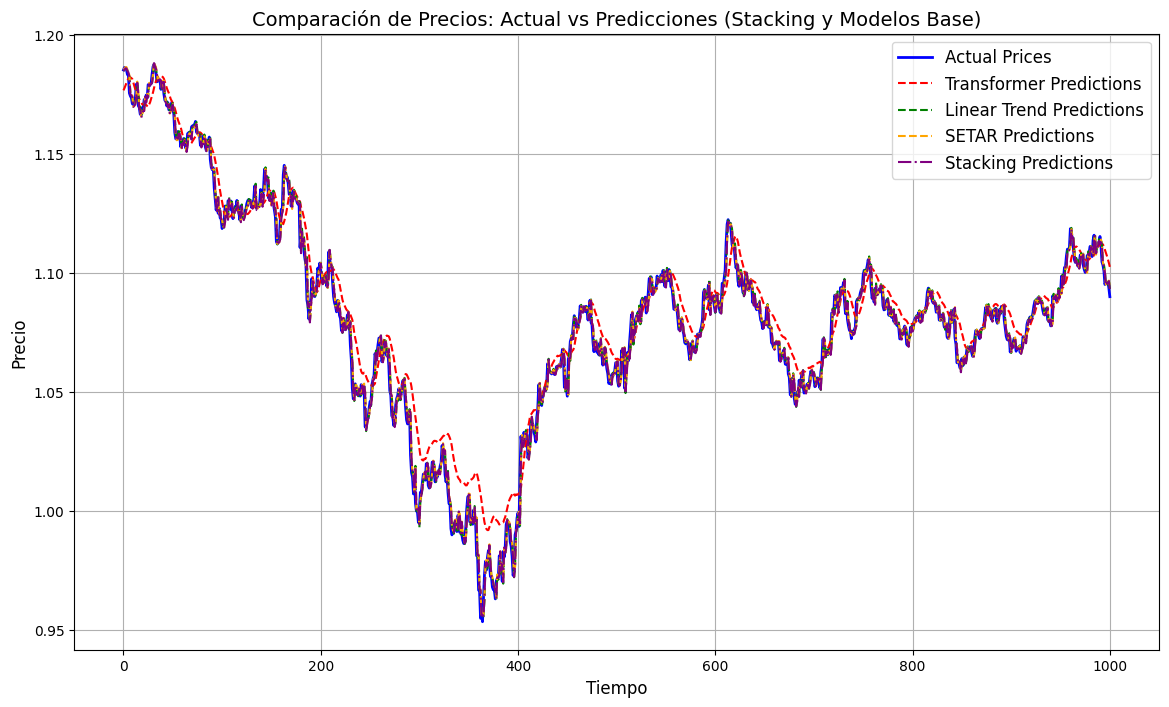

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(stacked_target, label='Actual Prices', color='blue', linewidth=2)
plt.plot(predictions_transformer, label='Transformer Predictions', color='red', linestyle='--')
plt.plot(predictions_LT, label='Linear Trend Predictions', color='green', linestyle='--')
plt.plot(predictions_SETAR, label='SETAR Predictions', color='orange', linestyle='--')
plt.plot(meta_predictions, label='Stacking Predictions', color='purple', linestyle='-.')
plt.title('Comparación de Precios: Actual vs Predicciones (Stacking y Modelos Base)', fontsize=14)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Precio', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.show()

Prediccion final del metamodelo

###### Obtener predicciones

In [47]:
# Predicción del Transformer
with torch.no_grad():
    transformer_prediction = model(last_window_tensor).item()
    transformer_prediction = scaler.inverse_transform([[transformer_prediction]])[0][0]  # Desnormalizar

# Predicción del modelo Linear Regression (LT)
last_window_LT = last_window.reshape(1, -1)
lt_prediction = model_LT.predict(last_window_LT)[0]

# Predicción del modelo SETAR
last_regime = assign_regime(last_window[-1], threshold)  # Determinar régimen
if last_regime == 0:
    setar_prediction = model_regime_0.predict(last_window_LT)[0]
else:
    setar_prediction = model_regime_1.predict(last_window_LT)[0]

###### Crear las caracteristicas del metamodelo

In [48]:
meta_features = np.array([[transformer_prediction, lt_prediction, setar_prediction]])

### Mediciones


Métricas para el modelo: Transformer
  - Mean Absolute Error (MAE): 0.0082
  - Mean Absolute Percentage Error (MAPE): 0.78%
  - R-squared (R²): 0.9388
  - Standard Deviation of Residuals: 0.0098
  - Tracking Error: 2.9373

Métricas para el modelo: Linear Trend (LT)
  - Mean Absolute Error (MAE): 0.0030
  - Mean Absolute Percentage Error (MAPE): 0.28%
  - R-squared (R²): 0.9914
  - Standard Deviation of Residuals: 0.0041
  - Tracking Error: 0.1976

Métricas para el modelo: SETAR
  - Mean Absolute Error (MAE): 0.0030
  - Mean Absolute Percentage Error (MAPE): 0.28%
  - R-squared (R²): 0.9915
  - Standard Deviation of Residuals: 0.0041
  - Tracking Error: 0.1705

Métricas para el modelo: Stacking (Metamodel)
  - Mean Absolute Error (MAE): 0.0030
  - Mean Absolute Percentage Error (MAPE): 0.28%
  - R-squared (R²): 0.9916
  - Standard Deviation of Residuals: 0.0041
  - Tracking Error: 0.0478


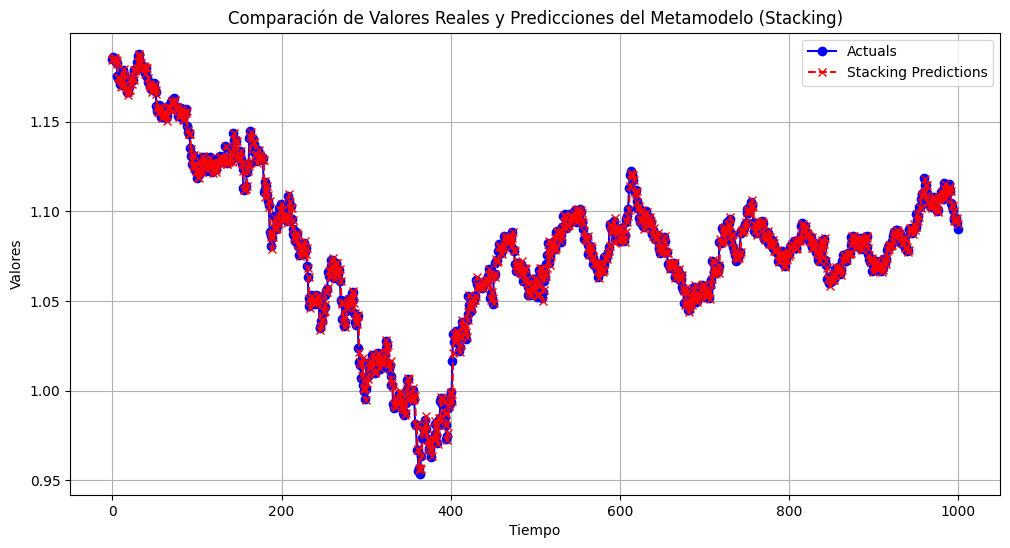

In [49]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Valores reales y predicciones por modelo
actuals = stacked_target  # Valores reales
models = {
    "Transformer": predictions_transformer,
    "Linear Trend (LT)": predictions_LT,
    "SETAR": predictions_SETAR,
    "Stacking (Metamodel)": meta_predictions
}

# Calcular métricas para cada modelo
for model_name, predictions in models.items():
    print(f"\nMétricas para el modelo: {model_name}")
    
    # 1. Mean Absolute Error (MAE)
    mae = mean_absolute_error(actuals, predictions)
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")

    # 2. Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    # 3. R-squared (R²)
    r2 = r2_score(actuals, predictions)
    print(f"  - R-squared (R²): {r2:.4f}")

    # 4. Standard Deviation of Residuals
    residuals = actuals - predictions
    std_residuals = np.std(residuals)
    print(f"  - Standard Deviation of Residuals: {std_residuals:.4f}")

    # 5. Tracking Error
    cumulative_actuals = np.cumsum(actuals)
    cumulative_predictions = np.cumsum(predictions)
    tracking_error = np.mean(np.abs(cumulative_actuals - cumulative_predictions))
    print(f"  - Tracking Error: {tracking_error:.4f}")

# Visualización opcional del modelo de Stacking
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actuals', marker='o', linestyle='-', color='blue')
plt.plot(meta_predictions, label='Stacking Predictions', marker='x', linestyle='--', color='red')
plt.title('Comparación de Valores Reales y Predicciones del Metamodelo (Stacking)')
plt.xlabel('Tiempo')
plt.ylabel('Valores')
plt.legend()
plt.grid()
plt.show()

## Predicción final de Low

In [50]:
final_prediction_close = meta_model.predict(meta_features)[0]
print(f"Predicción final del meta-modelo (Stacking): {final_prediction_close}, como referencia esta predicción es para el dia 11/Octubre/2024, y ese día el precio bajo en 1.09260")

Predicción final del meta-modelo (Stacking): 1.0889364623234736, como referencia esta predicción es para el dia 11/Octubre/2024, y ese día el precio bajo en 1.09260


In [51]:
# Guardar el metamodelo en un archivo
joblib.dump(meta_model, 'metamodel_Low.pkl')

['metamodel_Low.pkl']